In [2]:
#Shows each individual plot along with which model best fits it
import pickle, math
import pandas as pd
import sqlite3
import random
import os
import itertools
exec(open('Imports.py').read()) #execfile('Imports.py')
import Modules.Funcs as funcs
from Modules.Classes import Simulation
from Modules.Classes import CopyTweak
from Modules.Classes import CopyTweakRep
from Modules.Classes import Packer
from Modules.Classes import PackerRep
from Modules.Classes import PackerEuc
from Modules.Classes import ConjugateJK13
from Modules.Classes import RepresentJK13
from scipy.stats import stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#plotting options
STAT_LIMS =  (-1.0, 1.0)
#Fit to only last trial?
fitlast = False
#Make plots?
doplots = True
saveplots = False
if fitlast:
    showlast = True
else:
    showlast = False #True = Show last even if fitting to all?
#Bootstrap parameters
nbootstraps = 1000

# if fitlast and showlast:
#     savedir = 'private/individual_modelcomp/fitlast'
# elif showlast:
#     savedir = 'private/individual_modelcomp/showonlylast/'
# elif fitlast:
#     savedir = 'private/individual_modelcomp/fitlast'
# else:
#     savedir = 'private/individual_modelcomp/showall'

# savefilename='modelvsppt{}_t.pdf'.format(corrtype)
# modeleaseDB = "pickles/modelease_corr{}.p".format(corrtype)

#Some plotting options
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 15}

#Specify simulation values
N_SAMPLES = 10000
WT_THETA = 1.5
MIN_LL = 1e-10

# Specify default dataname
dbname = 'experiments-5con.db'#'experiments-5con.db'#raw data
dataname_def = '5con'#'5con'#bestparms comes from here

# Specify default dataname
# dataname_def = 'pooled'#'nosofsky1986'#'NGPMG1994'
participant_def = 'all'
unique_trials_def = 'all'
dataname = dataname_def
execfile('validate_data.py')

bestparmdb = "pickles/chtc_gs_best_params_{}".format(src)


plt.rc('font', **font)

# get data from pickle
with open(pickledir+src, "rb" ) as f:
    trials = pickle.load( f )

# get best params pickle
#bestparmdb = "pickles/chtc_gs_best_params_all_data_e1_e2.p"
#bestparmdb = "pickles/chtc_gs_best_params_corrs.p"
with open(bestparmdb, "rb" ) as f:
    best_params_t = pickle.load( f )

#Rebuild it into a smaller dict
best_params = dict()
for modelname in best_params_t.keys():    
    best_params[modelname] = dict()
    for i,parmname in enumerate(best_params_t[modelname]['parmnames']):
        parmval = best_params_t[modelname]['bestparmsll']
        best_params[modelname][parmname] = parmval[i]
modelList = [Packer,RepresentJK13]
#modelList = [CopyTweak,CopyTweakRep,Packer, RepresentJK13,]                            

#Specify plot order
modelPlotOrder = np.array([[Packer,RepresentJK13],[CopyTweak,ConjugateJK13]])
#modelPlotOrder = np.array([[CopyTweak,CopyTweakRep],[Packer,RepresentJK13]])

#Prepare matched database    
# matchdb='../cat-assign/data_utilities/cmp_midbot.db'
        
unique_trials = 'all'
trials.task = task




In [3]:
#Create new trialset
con = sqlite3.connect(dbname)
participants = pd.read_sql_query("SELECT participant, condition from participants", con)
generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()

# create categories mapping                                                                             
mapping = pd.DataFrame(columns = ['condition', 'categories'])
for i in alphas.columns:
    As = alphas[i].values.flatten()
    mapping = mapping.append(
        dict(condition = i, categories =[As]),
        ignore_index = True
    )

# merge categories into generation                                                                      
generation = pd.merge(generation, participants, on='participant')
generation = pd.merge(generation, mapping, on='condition')
#conditions = alphas.columns.values
conditions = ['Corner_S','Corner_C']
#Select only one participant
def generateOnePerm(condition,generation,stimuli):
#     genppt = generation.loc[generation.participant==ppt]
#     if order is None:
#         order = genppt.trial
#     if betas is None:
#         betas = genppt.stimulus
#     minlength = 1#min(len(order),len(betas))
#     while len(genppt)<minlength:
#         temprow = genppt.iloc[0]
#         genppt = genppt.append({'participant':temprow.participant,'stimulus':temprow.stimulus,'trial':max(genppt.trial)+1,'condition':temprow.condition,'categories':temprow.categories},ignore_index=True)
#     if alphas is None:
#         categories = genppt.categories
#     else:
#         categories = [[alphas] for i in range(minlength)]
#     #Extract only as much as the minimum specified order or beta allows
#     genppt = genppt[0:minlength]
#     genppt.trial = []#order[0:minlength]
#     genppt.stimulus = []#betas[0:minlength]
#     genppt.categories = categories[0:minlength]

    #Generate only the first trial no betas
    genppts = generation.loc[(generation.condition==condition)&(generation.trial==0)]
    genppt = genppts.iloc[0:1]
    # create trial set object                                                                               
    trials = Simulation.Trialset(stimuli)
    trials = trials.add_frame(genppt)
    trials.task = 'generate'
    trials._update
    return trials

In [114]:
temp = generation.loc[(generation.trial==0)&(generation.condition=='Corner_C')]
temp.iloc[0:1]

,category,participant,stimulus,trial,wrap_ax,condition,categories
1405,Beta,306,57,0,1.0,Corner_C,"[[0, 8, 72, 80]]"


In [130]:
generation.loc[generation.condition=='Corner_C'].wrap_ax.values[0]

1.0

In [116]:
#Get each alpha set
print(mapping)

  condition          categories
0   Cluster  [[14, 16, 32, 34]]
1       Row  [[10, 12, 14, 16]]
2       XOR   [[0, 10, 70, 80]]
3    Bottom  [[12, 14, 30, 32]]
4    Middle  [[30, 32, 48, 50]]
5  Corner_C    [[0, 8, 72, 80]]
6  Corner_S    [[0, 8, 72, 80]]


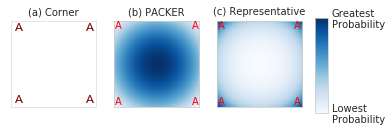

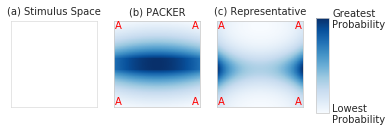

In [5]:
vals = np.linspace(-1, 1, 200).tolist()
space = np.fliplr(funcs.cartesian([vals, vals]))
lp = 60#80
fs = 10
nmodels = len(modelList)
nconditions = len(conditions)
adjplot = 1

# cond_labs = ['Squares','Circles']
plot_pre = ['(a)','(b)','(c)']

#Plot model predictions
for ci,condition in enumerate(conditions):
    f,ax = plt.subplots(1,nmodels+adjplot,figsize = (3*nmodels, 2))
    
    if ci==0:
        #Plot blank condition
        blankA = [0,8,72,80]
        funcs.plotclasses(ax[0], stimuli, blankA, [])
        ax[0].set_title('(a) Corner',fontsize=fs)
        #         ax[0].text(-2,1.5,'(a)',fontsize=fs+4)
        # ax[0,1].text(-150,220,'(b)',fontsize=fs+4)
        #         ax[1].set_title('(b)',fontsize=fs+4)
    else:
        funcs.plotclasses(ax[0], stimuli, [], [])    
        ax[0].set_title('(a) Stimulus Space',fontsize=fs)


    B = []
    ps = []
    ll_trial = []
    trialppt = generateOnePerm(condition,generation,stimuli)
    wrap_ax = generation.loc[(generation.trial==0)&(generation.condition==condition)][0:1].wrap_ax.values[0]
    if np.isnan(wrap_ax):
        wrap_ax = None
    for m,model in enumerate(modelList):        

        if len(ax.shape)>1:
            ax[0,m+adjplot].set_title('{} {}'.format(plot_pre[m+adjplot],model.modelshort),fontsize=fs)
#             ax[ci,adjplot].set_ylabel('{}'.format(cond_labs[ci]),rotation=0,labelpad=lp,fontsize=fs)
        else:                    
            ax[m+adjplot].set_title('{} {}'.format(plot_pre[m+adjplot],model.modelshort),fontsize=fs)
        
        if model is PackerEuc: #Gotta do this because I haven't fit PackerEuc to all data yet
            params = best_params[Packer.model]
        else:
            params = best_params[model.model]
        #Plot heatmap for each model
        categories = [trialppt.stimuli[i,:] for i in trialppt.Set[0]['categories'] if len(i)>0]
        ps += [model(categories,params,trialppt.stimrange,wrap_ax=wrap_ax).get_generation_ps(space,1,'generate')]
        #Get lls for each trial step
        ll_trial += [trialppt.loglike(params=params,model=model,parmxform=False,whole_array=True)]

#     Ai = alphas[condition].values.flatten()
    A = categories[0]
    #Plot the individual plots
    plotct = 0
    plotVals = []
    psMax = 0
    psMin = 1
    #Get range                                                                                                                                     
    for ps_el in ps:
        psMax = max(psMax,ps_el.max())
        psMin = min(psMin,ps_el.min())

    #Normalise all values                                                                                                                          
    psRange = psMax-psMin
    for i,ps_el in enumerate(ps): #each ps element correspond to a model
        plotct += 1
        gps = funcs.gradientroll(ps_el,'roll')[:,:,0]
#         plotVals += [gps]
        ps_ElRange = gps.max()-gps.min();
        plotVals += [(gps-gps.min())/ps_ElRange]  #Change ps_ElRange to psRange to normalize across all models                                                                           
        #Adjust Alphas for XOR and Corner for clarity of presentation
        if condition=='XOR':
            A = [[-.9,-.9],[-.65,-.65],[.65,.65],[.9,.9]]
        elif condition[:6]=='Corner':
            A = [[-.9,-.9],[-.9,.9],[.9,-.9],[.9,.9]]

        if len(ax.shape)>1:
            im = funcs.plotgradient(ax[ci,i+adjplot], plotVals[i], A, [], cmap = 'Blues',alpha_col='red')
        else:
            im = funcs.plotgradient(ax[i+adjplot], plotVals[i], A, [], cmap = 'Blues',alpha_col='red')
    #                     ax[i].set_ylabel('Trial {}'.format(trial))



    # plt.subplots_adjust(left=1)
    #Remove axes for unused plots
    # unusedax = [[1,0]]#[[0,1],[1,0],[1,1]]
    # for x,y in unusedax:
    #     ax[x,y].axis('off')

    # add colorbar
    f.subplots_adjust(right=0.8)
    cbar = f.add_axes([0.83, 0.16, 0.03, 0.66])
    f.colorbar(im, cax=cbar, ticks = [0, 1])
    cbar.set_yticklabels(['Lowest\nProbability', 'Greatest\nProbability'],fontsize=fs)
    cbar.tick_params(length = 0)

    #Save fig
    if saveplots:
        plt.savefig('private/firstbetas_corner{}.pdf'.format(condition),bbox_inches='tight')
    




#     savedirext = '{}/{}'.format(savedir,bestmodelstr)
#     if os.path.isdir(savedirext):
#         plt.savefig('{}/{}_{}_{}'.format(savedirext,pptconstr,int(ppt),bestmodelstr[0]))
#     else:
#         os.mkdir(savedirext)
#         plt.savefig('{}/{}_{}_{}'.format(savedirext,pptconstr,int(ppt),bestmodelstr[0]))

In [7]:
# categories = [[-1,-1],
#               [-.75,-.75],
#               [.75,.75],
#               [1,1]]
# categories = [[[-1,-1],
#               [-1,1],
#               [1,-1],
#               [1,1]]]
condition='Middle'
trialppt = generateOnePerm(condition,generation,stimuli)
categories = [trialppt.stimuli[i,:] for i in trialppt.Set[0]['categories'] if len(i)>0]
print(categories)

(ps,la1,lb1,sb,sa) = RepresentJK13(categories,best_params[RepresentJK13.model],trialppt.stimrange).get_generation_ps(space,1,'generate')
ps = ps[-200:-1]
# ps = ps-min(ps)
# ps = ps/max(ps)

la1 = la1[-200:-1]
# la = la-min(la)
# la = la/max(la)
lb1 = lb1[-200:-1]
# lb = lb-min(lb)
# lb = lb/max(lb)

f,ax = plt.subplots(1,3,figsize = (10,4))
ax[0].plot(ps)
ax[1].plot(la1)
ax[1].plot(lb1)
# ax[2].plot(la-lb)
# ax[2].plot(-np.log(la/lb))
ax[2].plot(np.log(lb1/la1))
ax[1].legend(['Alpha','Beta'])


[array([[-0.25, -0.25],
       [ 0.25, -0.25],
       [-0.25,  0.25],
       [ 0.25,  0.25]])]


ValueError: too many values to unpack

In [ ]:
# categories = [[-1,-1],
#               [-.75,-.75],
#               [.75,.75],
#               [1,1]]
categories = [[[-1,-1],
              [-1,1],
              [1,-1],
              [1,1]],[[0,0],[0,0],[0,0],[0,0]]]
# condition='XOR'
# trialppt = generateOnePerm(condition,generation,stimuli)
# categories = [trialppt.stimuli[i,:] for i in trialppt.Set[0]['categories'] if len(i)>0]
# print(categories)

(ps,la2,lb2,sb,sa) = RepresentJK13(categories,best_params[RepresentJK13.model],trialppt.stimrange).get_generation_ps(space,1,'generate')
ps = ps[-200:-1]
# ps = ps-min(ps)
# ps = ps/max(ps)
la2a = la2
la2 = la2[-200:-1]
# la = la-min(la)
# la = la/max(la)
lb2 = lb2[-200:-1]
# lb = lb-min(lb)
# lb = lb/max(lb)

f,ax = plt.subplots(1,3,figsize = (10,4))
ax[0].plot(ps)
ax[1].plot(la2)
ax[1].plot(lb2)
# ax[2].plot(la-lb)
# ax[2].plot(-np.log(la/lb))
ax[2].plot(np.log(lb2/la2))
ax[1].legend(['Alpha','Beta'])

# ax[1].plot(la1)
ax[1].plot(la2a[-20000:-19800])

In [ ]:
best_params['temp'] = best_params[RepresentJK13.model].copy()
best_params['temp']['domain_variance_bias'] = 1

In [ ]:
sa

In [ ]:
sb

In [ ]:
ps

In [ ]:
best_params[RepresentJK13.model]